## 1. Introduction

My wife and I have recently started to consider what life might look like after New York City. She's been here 15 years and I've been here 10 and we both agree that it's time for a change. One of the cities at the top of our list is Denver, Colorado and one of the appealing features of the city is that, unlike New York, we could afford to buy a house there. This got me thinking--how can I use data science to learn more about the real estate situation in Denver? 

We aren't looking to buy immediately, so my data analysis will focus on finding factors (both favorable and unfavorable) that affect buyers.

Fortunately for me, Denver has a great open data catalog: https://www.denvergov.org/opendata/. One of the datasets available is [Real Property Sales and Transfers](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-real-property-sales-and-transfers) which contains all records of property ownership transfers from 2008 to the present. What luck! A second dataset titled [Real Property Residential Characteristics](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-real-property-residential-characteristics) will be used to add additional information such as number of bedrooms and square footage to my analysis.

## 2. The Datasets

The Real Property Sales and Transfers dataset includes records of all sales and transfers of property in Denver. The Real Property Residential Characteristics dataset contains information about each home such as number of bedrooms and square footage. There are several duplicate columns between the two datasets, so I can be more selective in which columns are imported. 

Both datasets are in relatively good shape and don't require much work to clean.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from xml.etree import ElementTree as ET
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics

plt.style.use('ggplot')

%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df_sales = pd.read_csv('datasets/real_property_sales_and_transfers.csv')
df_characteristics = pd.read_csv('datasets/real_property_residential_characteristics.csv', usecols=['PIN',
                                                                                          'LAND_SQFT',
                                                                                          'AREA_ABG',
                                                                                          'BSMT_AREA', 
                                                                                          'FBSMT_SQFT',
                                                                                          'GRD_AREA',
                                                                                          'BED_RMS',
                                                                                          'FULL_B',
                                                                                          'HLF_B',
                                                                                          'STYLE_CN',
                                                                                          'STORY',
                                                                                          'CCYRBLT',
                                                                                          'CCAGE_RM',
                                                                                          'ASMT_APPR_LAND',
                                                                                          'TOTAL_VALUE',
                                                                                          'ASDLAND',
                                                                                          'ASSESS_VALUE',
                                                                                          'ASMT_TAXABLE',
                                                                                          'ASMT_EXEMPT_AMT',
                                                                                          'LEGL_DESCRIPTION'], 
                                                                                          error_bad_lines=False)

C:\Users\Trent\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
Skipping line 63332: expected 46 fields, saw 47
Skipping line 63335: expected 46 fields, saw 47
Skipping line 63338: expected 46 fields, saw 47

Skipping line 68348: expected 46 fields, saw 48
Skipping line 69469: expected 46 fields, saw 47
Skipping line 69470: expected 46 fields, saw 47
Skipping line 69471: expected 46 fields, saw 47
Skipping line 69472: expected 46 fields, saw 47



### df_sales Data Dictionary

In [3]:
sales_dict = pd.read_excel('datasets/RealPropertyMetaData.xlsx', sheetname='Sales_Transfers', header=3, parse_cols=[1,2,3,5])
sales_dict

,Field Name,Example,Column Type,Description
0,PIN,163752899,Text,Assessor's Property Identification Number
1,SCHEDNUM,0231416005000,Text,Assessor's Schedule Number
2,RECEPTION_NUM,2011148564,Text,Clerk & Recorder's Reception Number
3,RECEPTION_DATE,20101004,Text,Clerk & Recorder's Reception Date
4,INSTRUMENT,WD,Text,Type of Instrument
5,SALE_YEAR,2010,Text,Sale Year
6,SALE_MONTHDAY,0928,Text,Sale Month/Day
7,SALE_PRICE,199677,Text,Sale Price
8,GRANTOR,"SMITH, JOHN & JANE",Text,Person(s) relinquishing ownership
9,GRANTEE,"BROWN, JAMES",Text,Person(s) recieving ownership


### df_characteristics Data Dictionary

In [4]:
characteristics_dict = pd.read_excel('datasets/RealPropertyMetaData.xlsx', 
                                     sheetname='Residential_Characteristics', 
                                     header=3, 
                                     parse_cols=[1,2,3,5],
                                     skiprows=[5,6,7,8,9,10,11,12,13,14,15,16, 17,18,19,20,21,22,23,24,25,26,27,40])
characteristics_dict

,Field Name,Example,Column Type,Description
0,PIN,161714761,Text,Assessor's Property Identification Number
1,LAND_SQFT,6241,Long Integer,Land Area
2,AREA_ABG,1411,Long Integer,Above Grade Improvement Area
3,BSMT_AREA,389,Long Integer,Basement Square Footage
4,FBSMT_SQFT,389,Long Integer,Finished Basement Area
5,GRD_AREA,0,Long Integer,Garden Level Square Footage
6,STORY,1,Float,Stories
7,STYLE_CN,TWO-STORY,Text,Architecture Style Code Definition
8,BED_RMS,3,Short Integer,Number of bedroom above grade
9,FULL_B,2,Short Integer,Total number of full baths


## 3. Data Wrangling

### Filtering the dataset to only show single family home sales

All property types are included in this dataset, but I'm not interested in commercial properties or apartments, so I'm going to filter all of those out and only keep the records of single family homes.

I'm also going to remove any records that have a sale price less than \$100,000 and more than \$500,000. Anything with a sale price less than \$50,000 indicates to me that there are some issues with the data and anything over \$500,000 is way out of my range. The next plot shows that while the number of home sales has fluctuated from year to year, the mean sale price has consistently gone up since 2009.

That leaves me with just under 64,000 records to work with.

A quick look at the number of home sales and transfers each year shows that 2013 and 2014 were the biggest years in the dataset in terms of volume. The volume in 2015 decreased slightly. 

_Note: The dip in 2016 sales and transfers can be attributed to incomplete data since the year isn't complete._

In [5]:
single_family_home = 'SINGLE FAMILY'

df_sales = df_sales[df_sales.D_CLASS_CN == single_family_home]
df_sales.shape

df_sales = df_sales[(df_sales.SALE_PRICE > 100000) & (df_sales.SALE_PRICE < 500000)]
df_sales.shape

(58615, 16)

### Adding datetime and setting it as the index

It would also be interesting to dig a little deeper into the trends that might exist in sales and transfers over time. In order to do this, I'll need to convert the SALE_YEAR and SALE_MONTHDAY columns into a new column with datetime formatting. 

In [6]:
days = []
months = []
years = df_sales.SALE_YEAR.astype(str)
datetimes = []

for row in df_sales.SALE_MONTHDAY:
    row = str(row)
    if len(row) < 4:
        row = '0' + row
    days.append(row[:-2])
    months.append(row[2:])
    
df_sales['date'] = years + '-' + months + '-' + days

df_sales['date'] = pd.to_datetime(df_sales['date'], format='%Y-%d-%m')

df_sales.index = df_sales.date

df_sales['year'] = df_sales.index.year
df_sales['month'] = df_sales.index.month
df_sales['day'] = df_sales.index.day

### Combining the two datasets

I also need to add any matching records in the characteristics dataset to the sales dataset. Since I don't care about any records in the characteristics dataset that aren't also in the sales dataset, they will simply be dropped. Both datasets have a matching PIN column, which is a unique identifier for each property, that will be used to join them.

In [7]:
df_full_info = df_sales.merge(df_characteristics, how='left', on='PIN')
df_full_info.dropna(inplace=True)

## 4. Exploratory Data Analysis

Comparing the number of monthly sales each year shows that there is a trend of more sales in the spring and summer compared to fall and winter.

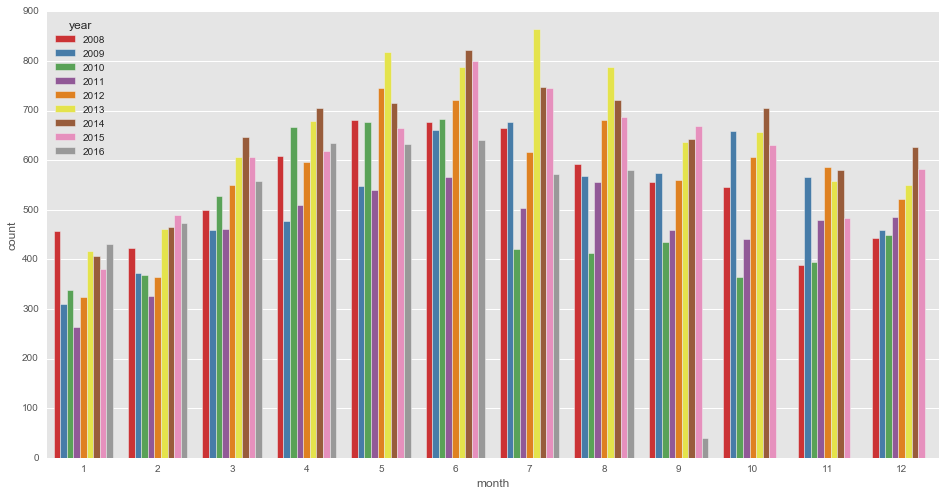

In [8]:
#TODO: Replace x axis markers (1-12) with month names
fig = plt.figure(figsize=(16,8))
ax = sns.countplot(x="month", hue="year", data=df_sales, palette="Set1")

plt.show()

Looking at the sales for just the seasons illustrates this trend more clearly.

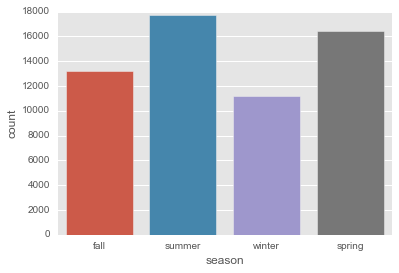

In [9]:
#TODO: Put seasons in order: Winter, Spring, Summer, Fall
#TODO: Capitalize seasons
season = []

for m in df_full_info.month:
    if m in (3,4,5):
        season.append('spring')
    elif m in (6,7,8):
        season.append('summer')
    elif m in (9, 10, 11):
        season.append('fall')
    elif m in (12, 1, 2):
        season.append('winter')

df_full_info['season'] = season

sns.countplot(x='season', data=df_full_info);

So, the number of sales is higher in the Spring and Summer, but what about the mean sale price of homes? As the two plots below illustrate, the mean sale price of homes is also higher in Spring and Summer.

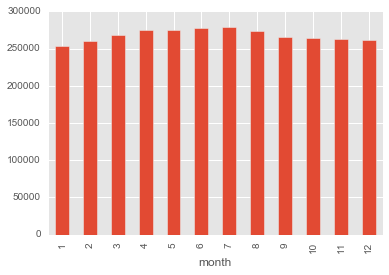

In [10]:
#TODO: Change x axis markers from 1-12 to January-December
df_full_info.groupby('month').SALE_PRICE.mean().plot(kind='bar');

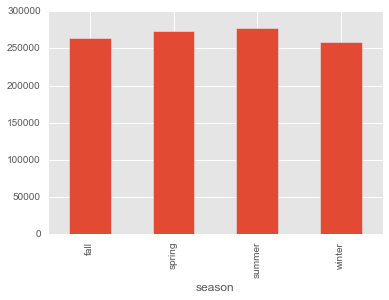

In [11]:
#TODO: put seasons in order Winter, Spring, Summer, Fall
#TODO: capitalize seasons on x axis
df_full_info.groupby('season').SALE_PRICE.mean().plot(kind='bar');

The first plot below shows the mean sale price in Denver has been steadily increasing each year since 2009. In 2009 the mean sale price of a single family home in Denver was around \$233,000 and so far in 2016, the mean sale price is almost \$327,000. Assuming an increase in sale prices is correlated with an increase in the popularity of a neighborhood, seeing which neighborhoods have the largest increase in mean price should also give us an idea of which neighborhoods have become more popular over the past six years.

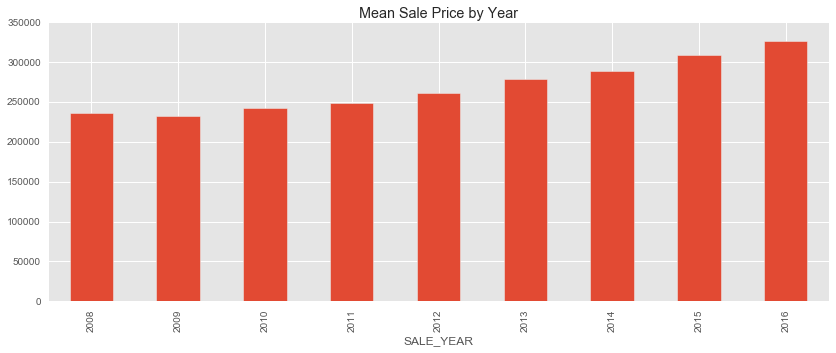

In [12]:
df_sales.groupby('SALE_YEAR')['SALE_PRICE'].mean().plot('bar', figsize=(14,5), title="Mean Sale Price by Year");

In [13]:
nbhd_yearly_sale_means = df_full_info.groupby(['NBHD_1_CN', 'year']).SALE_PRICE.mean()

nbhd_yearly_sale_means = nbhd_yearly_sale_means.unstack()
nbhd_yearly_sale_means.head()

year,2008,2009,2010,2011,2012,2013,2014,2015,2016
NBHD_1_CN,,,,,,,,,
ACADEMY,179833.333,198112.500,197100.000,209625.000,202700.000,198291.667,252405.556,283030.769,323390.000
ARAPAHOE SQUARE,nan,nan,nan,nan,nan,nan,nan,nan,261000.000
ATHMAR PARK,141321.394,142407.646,138224.662,134638.915,148005.325,170305.476,199156.015,231378.642,263607.636
AVONDALE,159305.824,175404.000,177295.125,200046.938,210039.263,227712.567,297735.294,313136.667,338210.526
BAKER,272154.672,272373.648,280244.500,298928.809,312535.152,351710.509,370989.022,370359.147,423445.833


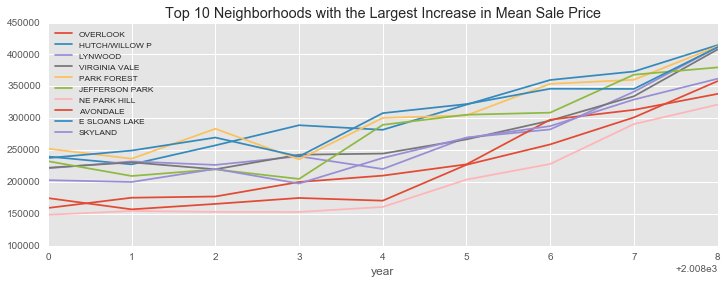

In [14]:
#TODO: change the x axis markers from 0-8 to 2009-2016.
nbhd_yearly_sale_means['2009 to 2016 difference'] = nbhd_yearly_sale_means[2016] - nbhd_yearly_sale_means[2009]

ax = nbhd_yearly_sale_means.sort_values(by='2009 to 2016 difference', ascending=False).drop('2009 to 2016 difference', axis=1).head(10).transpose().plot(figsize=(12, 4));
plt.title('Top 10 Neighborhoods with the Largest Increase in Mean Sale Price')
plt.legend(loc=0, fontsize='small');

The plot above shows the ten neighborhoods with the largest increase in mean sale price from 2009 to 2016. As a prospective home buyer, a popular neighborhood is nice, but so is a lower home price, so it's good to see that the most popular neighborhoods have an almost \$100,000 range in mean price.

## 5. Modelling

Now that I have an idea of some of the general trends in the data, I'll want to work on a model to help predict the final sale price of a property. First, the feature variables need to be separated from the outcome variable (sale price). The categorical feature variables will also be divided into dummy variables in order for the regression to work properly.

In [15]:
all_features = df_full_info.drop('SALE_PRICE', axis=1)
numerical_features = all_features.select_dtypes(exclude=['object', 'datetime64'])

X_features = numerical_features.dropna()
y = df_full_info['SALE_PRICE']

month_dummies = pd.get_dummies(df_full_info.month, prefix='month', drop_first=True)
nbhd_dummies = pd.get_dummies(df_full_info.NBHD_1_CN, prefix = 'nbhd', drop_first=True)
story_dummies = pd.get_dummies(df_full_info.STORY, prefix = 'story', drop_first=True)
season_dummies = pd.get_dummies(df_full_info.season, prefix = 'season', drop_first=True)

features = ['AREA_ABG', 'BSMT_AREA', 'ASMT_TAXABLE', 'GRD_AREA', 'CCYRBLT', 'year', 'LAND_SQFT', 'FBSMT_SQFT', 'BED_RMS', 'FULL_B', 'HLF_B', 'CCAGE_RM']

X = df_full_info[features]
X = pd.concat([X, nbhd_dummies, story_dummies, month_dummies, season_dummies], axis=1)

Now, the data will be split into training and validation sets. The training set will be used to refine the models, and once the refinement is done, the validation set will be used to see how accurate the model is with new data.

In [16]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=.33, random_state=42)

### Linear Regression

The first model I'm going to run on the data is a linear regression. First I'll split the data into training and testing sets. Then I'll run a 10 fold cross-validation on the training set. The metric I'm most interested in at this point is the root mean squared error, wich will tell me the mean error of the model in actual dollars. I also want to compare the r-squared of the model on a training and testing set to make sure it isn't overfitting to the training data, so the function below divides the data into those sets.

In [17]:
def linear_model(X, y, n_folds=4, random_state=42):
    y_train_true = []
    y_train_pred = []
    y_test_true = []
    y_test_pred = []

    folds = KFold(y.size, n_folds=n_folds, random_state=42)

    for train, test in folds:
        model = LinearRegression()
        model.fit(X.iloc[train], y.iloc[train])
        
        [y_train_true.append(t) for t in y.iloc[train]]
        [y_train_pred.append(t) for t in model.predict(X.iloc[train])]
        [y_test_true.append(result) for result in y.iloc[test]]
        [y_test_pred.append(result) for result in model.predict(X.iloc[test])] 
    
    rsquared_train = metrics.r2_score(y_train_true, y_train_pred)
    rsquared_test  = metrics.r2_score(y_test_true, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))   
    
    return pd.DataFrame({
            "R^2 Train": rsquared_train, 
            "R^2 Test": rsquared_test, 
            "RMSE Train": rmse_train,
            "RMSE Test": rmse_test
        }, index=[model.__class__.__name__])

In [18]:
linear_model(X_train, y_train, n_folds=10)

,RMSE Test,RMSE Train,R^2 Test,R^2 Train
LinearRegression,61285.990,60877.510,0.663,0.668


Not great, but it's a starting point. A few attempts at improving the linear model didn't make great gains, so I'm going to try a random forest model as an alternative.

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
def forest_model(X, y, max_features='auto', 
                       max_depth=None,
                       test_size=.33, 
                       n_folds=4, 
                       min_samples_split=2,
                       min_samples_leaf=1,
                       random_state=42):
    y_train_true = []
    y_train_pred = []
    y_test_true = []
    y_test_pred = []
    
    folds = KFold(y.size, n_folds=n_folds, random_state=random_state)

    for train, test in folds:
        forest = RandomForestRegressor(max_features=max_features, 
                                       max_depth=max_depth, 
                                       random_state=random_state,
                                       min_samples_split=min_samples_split, 
                                       min_samples_leaf=min_samples_leaf)
        forest.fit(X.iloc[train], y.iloc[train])
        
        [y_train_true.append(t) for t in y.iloc[train]]
        [y_train_pred.append(t) for t in forest.predict(X.iloc[train])]
        [y_test_true.append(result) for result in y.iloc[test]]
        [y_test_pred.append(result) for result in forest.predict(X.iloc[test])]
    
    rsquared_train = metrics.r2_score(y_train_true, y_train_pred)
    rsquared_test  = metrics.r2_score(y_test_true, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))   
    
    return pd.DataFrame({
            "R^2 Train": rsquared_train, 
            "R^2 Test": rsquared_test, 
            "RMSE Train": rmse_train,
            "RMSE Test": rmse_test
        }, index=[model.__class__.__name__])

In [21]:
forest_model(X_train, y_train)

NameError: global name 'model' is not defined

The random forest model performs significantly better than the linear model even though it is currently overfitting on the training data, so I'm going to focus my efforts on refining that model. My next test will be to put the feature variables into a K-Means clustering model.

In [ ]:
from sklearn import cluster

In [ ]:
kmeans = cluster.KMeans(n_clusters=5, n_init=10, init='random')
cluster_predictions = kmeans.fit_predict(df_full_info[features])
df_full_info['cluster'] = cluster_predictions

In [ ]:
cluster_dummies = pd.get_dummies(df_full_info.loc[X_train.index].cluster, prefix='cluster', drop_first=True)

X_train_cluster = pd.concat([X_train, cluster_dummies], axis=1)

In [ ]:
forest_model(X_train_cluster, y_train)

That actually made my model slightly _less_ accurate, so I chose to spend my time refining the parameters of the original modelstick with the original model and instead spend my

### Feature Correlations

Next we're going to have a look at all of the features and whether any are highly correlated with each other. If they are, then removing those highly correlated features should help to improve the model.

In [ ]:
plt.figure(figsize=(15,12))
ax = sns.heatmap(X_features.corr())
plt.title("Feature Correlations")

plt.show()

The correlation heatmap above shows that there are definitely variables that are highly correlated with each other and should be dropped. After looking through the heatmap, I have chosen to keep the following variables:

In [ ]:
features = ['AREA_ABG', 
            'BSMT_AREA', 
            'ASMT_TAXABLE', 
            'CCYRBLT', 
            'year', 
            'LAND_SQFT', 
            'BED_RMS', 
            'FULL_B', 
            'CCAGE_RM']

X = X_features[features]
X = pd.concat([X, month_dummies, nbhd_dummies], axis=1)
y = df_full_info['SALE_PRICE']

In [ ]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=.33, random_state=42)

In [ ]:
forest_model(X_train, y_train)

It's still overfitting, but it does perform slightly better with the reduced features. After working on tuning the model, I ended up with the following:

In [ ]:
forest_model(X_train, y_train, max_features=140, 
                       max_depth=30,
                       min_samples_split=70,
                       min_samples_leaf=4)

Now let's run the model with the validation data we set aside at the beginning of the modelling phase.

In [ ]:
forest_model(X_validate, y_validate, max_features=140, 
                       max_depth=30,
                       min_samples_split=70,
                       min_samples_leaf=4)

The results of the model are very close to the training data, which gives me confidence that the model works well with new data.

## 6. Takeaways

One of the main takeaways from the analysis is that seasons affect both the number of houses sold and the mean price of those houses. For the best deals, I would recommend for myself or any new home buyer to wait until the Winter months to purchase a home. One caveat to this recommendation is that the dataset doesn't contain any information about the number of homes for sale throughout the year, but I would assume there are fewer for sale as well. There's also the issue of moving in the middle of winter, but if you can find a home you would like to live in, it could save you \$25,000-\$30000 dollars.

Based on the yearly comparisons, Denver is a popular city at the moment, but there are neighborhoods along a spectrum of price ranges that seem to be gaining in popularity and are worth a look.

## 7. Next Steps

My next step for improving the accuracy of the model is to incorporate additional data. Denver's open data catalog includes two datasets that are of particular interest. The first is a [crime dataset](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-crime) that contains information on crimes in the current calendar year as well as the previous five years. The second dataset is the [American Community Survey Nbrhd (2010-2014)](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-american-community-survey-nbrhd-2010-2014) dataset. It contains neighborhood level demographic information collected from the [American Community Survey](http://www.census.gov/programs-surveys/acs/).

Another next step I would like to take with this data is to plot it geographically and begin to explore the spacial relationships in the data. Many of the datasets on Denver's open data catalog contain shapefiles that should make it an achievable goal.